# Analysis of text content of tweets
## Soledad Galli, PhD
### January 28th, 2016

In [46]:
data = read.csv('Tweets.csv')
library(dplyr)
data = select(data,airline_sentiment, negativereason, airline, text)
head(data)

,airline_sentiment,negativereason,airline,text
1,neutral,,Virgin America,@VirginAmerica What @dhepburn said.
2,positive,,Virgin America,@VirginAmerica plus you've added commercials to the experience... tacky.
3,neutral,,Virgin America,@VirginAmerica I didn't today... Must mean I need to take another trip!
4,negative,Bad Flight,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
5,negative,Can't Tell,Virgin America,@VirginAmerica and it's a really big bad thing about it
6,negative,Can't Tell,Virgin America,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA


Every tweet begins with a @airline tag, which indicates the airline towards which the message is directed. To analyse the content of the tweet, this part is not relevant, so it will be removed from the tweet texts.

In [47]:
# Remove the @airline bit of the text of the tweet
data$text = gsub("^@\\w+ *", "", data$text)
head(data)

,airline_sentiment,negativereason,airline,text
1,neutral,,Virgin America,What @dhepburn said.
2,positive,,Virgin America,plus you've added commercials to the experience... tacky.
3,neutral,,Virgin America,I didn't today... Must mean I need to take another trip!
4,negative,Bad Flight,Virgin America,"it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
5,negative,Can't Tell,Virgin America,and it's a really big bad thing about it
6,negative,Can't Tell,Virgin America,seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA


We can see now, that the tweets do not contain the @airline tag. They are ready to be processed. Tweets classified as negative or positive will be analysed separately.

In [48]:
# divide tweets in 2 dataframes according to positive or negative sentiment
positive = subset(data, airline_sentiment == 'positive')
negative = subset(data, airline_sentiment == 'negative')
dim(positive); dim(negative)

[1] 2363    4

[1] 9178    4

We see that from the total amount of tweets (14640), 2363 have been clasified as positive and 9178 as negative.

## Determine word frequency and build cloud of words for each sentiment

In [49]:
library(tm); library(SnowballC)
library(wordcloud)

# these words appear quite frequently in tweets and in my opinion are not informative,
# so I will remove them"
wordsToRemove = c('get', 'cant', 'can', 'now', 'just', 'will', 'dont', 'ive', 'got', 'much')

# generate a function to analyse corpus text
analyseText = function(text_to_analyse){
    # analyse text and generate matrix of words
    # Returns a dataframe containing 1 tweet per row, one word per column
    # and the number of times the word appears per tweet
    CorpusTranscript = Corpus(VectorSource(text_to_analyse))
    CorpusTranscript = tm_map(CorpusTranscript, content_transformer(tolower), lazy = T)
    CorpusTranscript = tm_map(CorpusTranscript, PlainTextDocument, lazy = T)
    CorpusTranscript = tm_map(CorpusTranscript, removePunctuation)
    CorpusTranscript = tm_map(CorpusTranscript, removeWords, wordsToRemove)
    CorpusTranscript = tm_map(CorpusTranscript, removeWords, stopwords("english"))
    CorpusTranscript = DocumentTermMatrix(CorpusTranscript)
    CorpusTranscript = removeSparseTerms(CorpusTranscript, 0.97) # keeps a matrix 97% sparse
    CorpusTranscript = as.data.frame(as.matrix(CorpusTranscript))
    colnames(CorpusTranscript) = make.names(colnames(CorpusTranscript))
    
    return(CorpusTranscript)
}

In [50]:
words = analyseText(negative$text)
dim(words)

[1] 9178   30

The function has extracted 30 words (1 per column) that are repeated with certain frequency accross all negative tweets. Each column specifies how many times that specific word appeared in each tweet (in each row). The sum of the column specifies how many times that specific word was used altogether in all negative tweets.

In [51]:
# sum the number of times each word appears in total accross all negative tweets.
freqWords_neg = colSums(words)
freqWords_neg = freqWords_neg[order(freqWords_neg, decreasing = T)]
head(freqWords_neg)

flight cancelled   service     hours      help      hold 
     2901       920       740       644       610       607

We see for example that the word flight appeared 2901 times considering all negative tweets, and the word cancelled appeared 920 times.

In [52]:
# analysis of positive tweets
words = analyseText(positive$text)
dim(words)

[1] 2363   18

The function has determined 18 words that appear with certain frequency accross positive tweets.

In [53]:
freqWords_pos = colSums(words)
freqWords_pos = freqWords_pos[order(freqWords_pos, decreasing = T)]
head(freqWords_pos)

thanks   thank  flight   great service    love 
    608     453     373     233     160     133

As "thank" and "thanks" are conveying the same message, I will sumarise them in one column.

In [54]:
# combine thanks and remove extra column
freqWords_pos[1] = freqWords_pos[1] + freqWords_pos[2]
freqWords_pos = freqWords_pos[-2]
head(freqWords_pos)

thanks   flight    great  service     love customer 
    1061      373      233      160      133      113

We see that the word thanks appears 1061 times accross positive tweets, flight 373 times and so on.

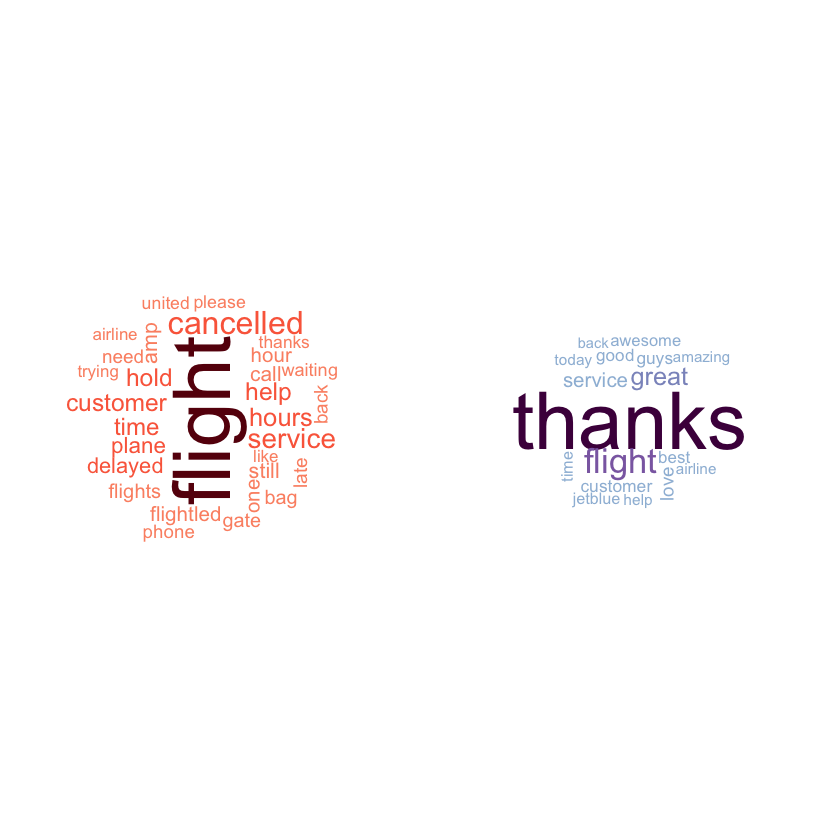

In [55]:
# word clouds
par(mfrow = c(1,2))

wordcloud(freq = as.vector(freqWords_neg), words = names(freqWords_neg),random.order = FALSE,
          random.color = FALSE, colors = brewer.pal(9, 'Reds')[4:9])

wordcloud(freq = as.vector(freqWords_pos), words = names(freqWords_pos),random.order = FALSE,
          random.color = FALSE, colors = brewer.pal(9, 'BuPu')[4:9])


The cloud of words provide a nice visual representation of the word frequency for each type of sentiment (negative: left or positive: right). The size of the word correlates with its frequency accross all tweets. We can get an idea of what people are talking about. For example, for negative sentiment, people seem to complain about cancelled or delayed flights, and hours waiting. However, for positive sentiment, people are mostly thankful and they talk about great service/flight.

In the following section, I will analyse the association between words, i.e., words that usually are mentioned together in tweets. 

In [56]:
# generate a function to analyse corpus text and return a document term matrix instead of dataframe
# we can perform further analysis on document term matrices
analyseText2 = function(text_to_analyse){
    # analyse text and generate matrix of words
    # Returns a dtm containing 1 tweet per row, one word per column
    # and the number of times the word appears per tweet
    CorpusTranscript = Corpus(VectorSource(text_to_analyse))
    CorpusTranscript = tm_map(CorpusTranscript, content_transformer(tolower), lazy = T)
    CorpusTranscript = tm_map(CorpusTranscript, PlainTextDocument, lazy = T)
    CorpusTranscript = tm_map(CorpusTranscript, removePunctuation)
    CorpusTranscript = tm_map(CorpusTranscript, removeWords, wordsToRemove)
    CorpusTranscript = tm_map(CorpusTranscript, removeWords, stopwords("english"))
    CorpusTranscript = DocumentTermMatrix(CorpusTranscript)
    CorpusTranscript = removeSparseTerms(CorpusTranscript, 0.97) # keeps a matrix 97% sparse
    
    return(CorpusTranscript)
}

In [57]:
words_neg = analyseText2(negative$text)
# find words correlated with the ones mentioned below (correlation at 70%)
findAssocs(words_neg, c("flight", 'customer', 'gate', 'phone'), .07)

$flight
cancelled      late flightled   delayed 
     0.36      0.25      0.23      0.16 

$customer
service 
   0.65 

$gate
waiting   plane 
   0.09    0.08 

$phone
help 
0.07

We see that in negative tweets, the appearance of the word flight correlates with the appearance of the words cancelled, late and delayed, indicating that people are complaining about delayed flights. The word customer is associated with the word service, which is expected, as customer service was a recurrent issue in negative tweets. Interestingly, the word gate is associated with the words waiting and plane, which probably means that people were left waiting at the gate for some time before departure.
So from this study, and without having read any tweet, we understand that people are generally complaining about.

In [58]:
words_pos = analyseText2(positive$text)
findAssocs(words_pos, c("flight", 'awesome', 'amazing', 'service'), .07)

$flight
great 
 0.13 

$awesome
guys 
0.07 

$amazing
customer 
    0.08 

$service
customer    great    today 
    0.66     0.16     0.08

For positive sentiment tweets, we observe that the word flight is associated with great, suggesting that people have had great flight experiences. The word service is associated with the word amazing, which is in turn associated with the word service, indicating that people experienced an amazing customer service in many opportunities. Similarly, without having actually read any tweet, with this analysis we get an idea of what people are saying about the airlines.

### To further understand the associations between words, we can make clustering analysis of words.

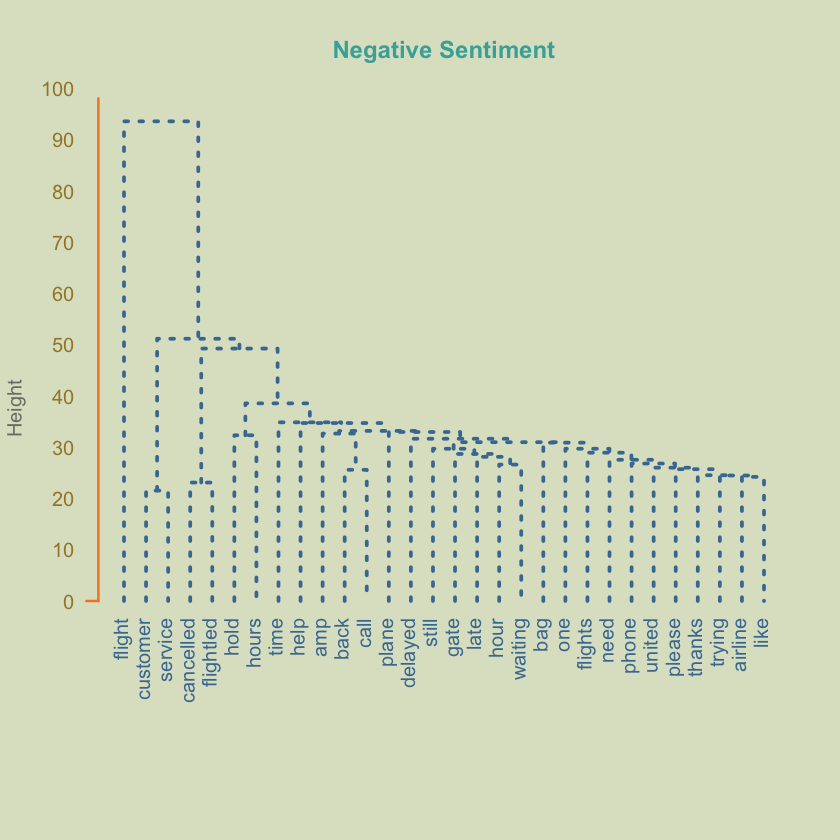

In [59]:
# hierarchical clustering
d = dist(t(as.matrix(words_neg)), method = 'euclidean')
fit = hclust(d = d, method = 'ward.D')

#fancy plot
op = par(bg = "#DDE3CA")
plot(fit, col = "#487AA1", col.main = "#45ADA8", col.lab = "#7C8071", main = 'Negative Sentiment', xlab = '',
     col.axis = "#F38630", lwd = 3, lty = 3, sub = "", hang = -1, axes = FALSE)
# add axis
axis(side = 2, at = seq(0, 400, 100), col = "#F38630", labels = FALSE, 
     lwd = 2)
# add text in margin
mtext(seq(0, 100, 10), side = 2, at = seq(0, 100, 10), line = 1, 
      col = "#A38630", las = 2)

In the dendrogram, words that are linked by short arms are highly associated (they are likely to appear together in the same tweet).

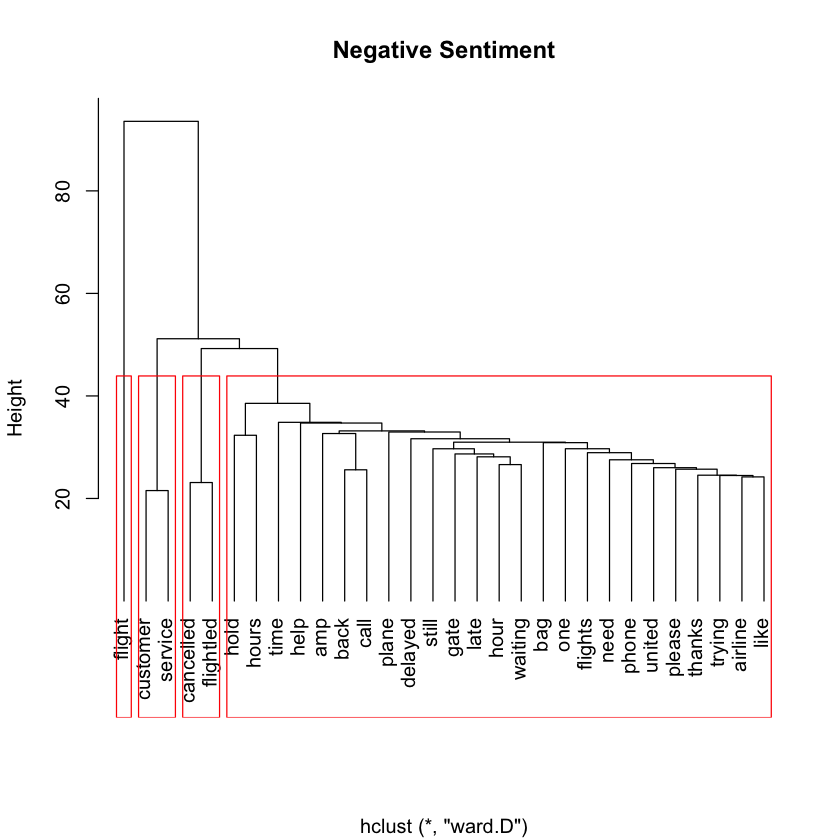

In [60]:
plot.new()
plot(fit, hang=-1, main = 'Negative Sentiment', xlab = '')
rect.hclust(fit, k=4, border="red")

Although the dendrogram does not seem to be particularly informative, we observe again the association of words like customer and service, and cancelled flight. Words that reflect complains more generally, like waiting, bag (presumably lost), hours, time, hold, cluster altogether.

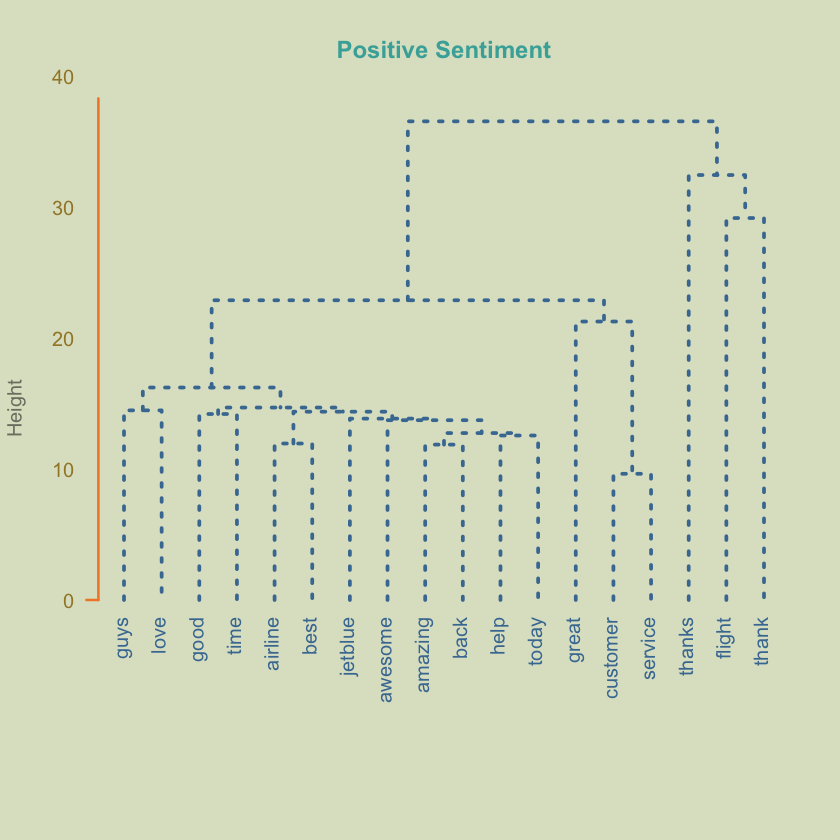

In [61]:
# positive sentiment tweets
d = dist(t(as.matrix(words_pos)), method = 'euclidean')
fit = hclust(d = d, method = 'ward.D')

#fancy plot
op = par(bg = "#DDE3CA")
plot(fit, col = "#487AA1", col.main = "#45ADA8", col.lab = "#7C8071", main = 'Positive Sentiment', xlab = '',
     col.axis = "#F38630", lwd = 3, lty = 3, sub = "", hang = -1, axes = FALSE)
# add axis
axis(side = 2, at = seq(0, 400, 100), col = "#F38630", labels = FALSE, 
     lwd = 2)
# add text in margin
mtext(seq(0, 100, 10), side = 2, at = seq(0, 100, 10), line = 1, 
      col = "#A38630", las = 2)

The positive tweet dendrogram is somewhat more informative. We can see the association of customer-service, and best-airline, or love-guys, good-time, which indicate more clearly, what the experience of the airline client was.

### k-means clustering

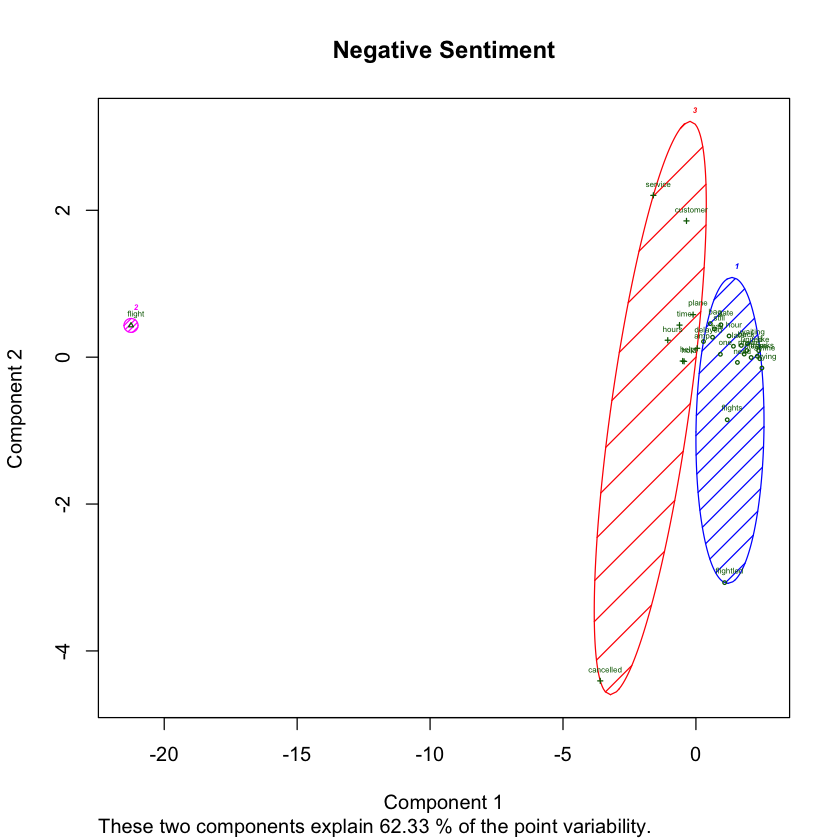

In [62]:
library(cluster)
d = dist(t(as.matrix(words_neg)), method="euclidean")   
kfit = kmeans(d, 3)   
clusplot(as.matrix(d), kfit$cluster, color=T, shade=T, labels=2, lines=0, cex = 0.4, main = 'Negative Sentiment')

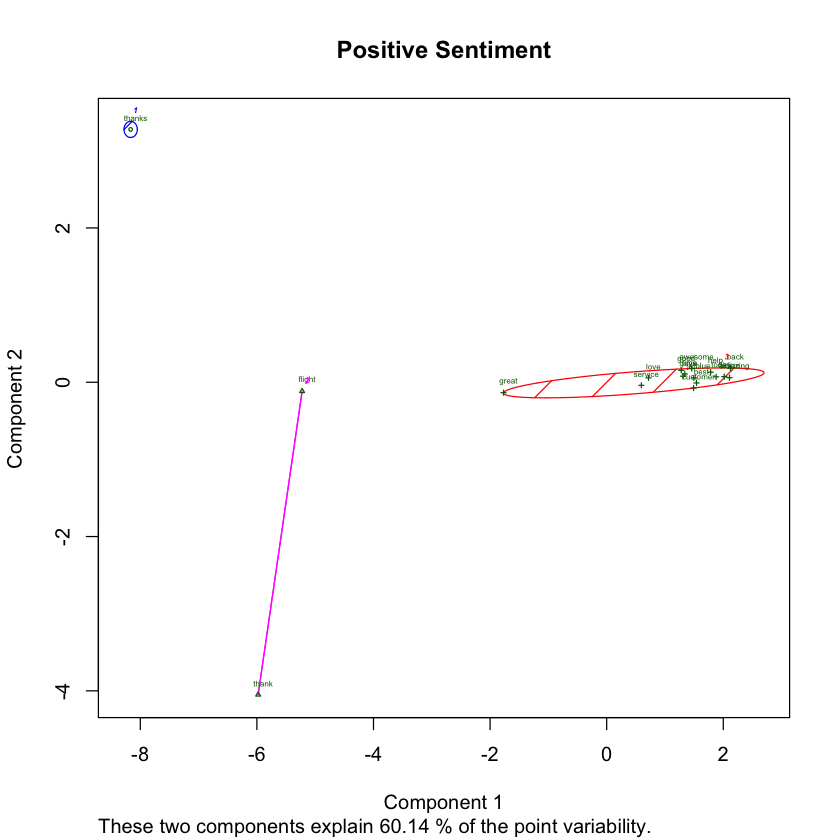

In [63]:
d = dist(t(as.matrix(words_pos)), method="euclidean")   
kfit = kmeans(d, 3)   
clusplot(as.matrix(d), kfit$cluster, color=T, shade=T, labels=2, lines=0, cex = 0.4, main = 'Positive Sentiment')

K-means clustering is another method that determines the proximity of words (which indicates which words are presumably used together). The cluster plots displayed above, however do not shade new light into what we have previously discovered from the text of these tweets. I leave them just to show what we can do in terms of basic text analytics.

## Conclusions

We conducted basic text analytics for the tweets. We displayed in word clouds with the frequency of words, the main topics of conversation in tweets with negative and positive sentiment. Then, we found associations between words that allowed us to better understand what the customers were complaining about, or why they enjoyed their flying experience.

In the next and final section, I will build a model to predict the sentiment of tweets based on their text and other characteristics.